In [0]:
import numpy as np
from sklearn.datasets import load_iris

In [0]:
!wget https://github.com/Qwicen/node/archive/master.zip
!mkdir node
!mv master.zip node
!unzip node/master.zip

--2020-04-30 10:21:14--  https://github.com/Qwicen/node/archive/master.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Qwicen/node/zip/master [following]
--2020-04-30 10:21:14--  https://codeload.github.com/Qwicen/node/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 239.72K   732KB/s    in 0.3s    

2020-04-30 10:21:15 (732 KB/s) - ‘master.zip’ saved [245473]

Archive:  node/master.zip
3bae6a8a63f0205683270b6d566d9cfa659403e4
   creating: node-master/
  inflating: node-master/.gitignore  
  inflating: node-master/LICENSE.md  
  inflating: node-master/R

In [0]:
!pip install -r node-master/requirements.txt

     / 9.4MB 1.2MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 55.5MB 50kB/s 
     |████████████████████████████████| 16.6MB 214kB/s 
     |████████████████████████████████| 204kB 41.4MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
  Created wheel for qhoptim: filename=qhoptim-1.1.0-cp36-none-any.whl size=20328 sha256=ea9d5c5f0dc32bea2d2d559d2e5ebfd5053041b2ae87a7c4327b34502cd940a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-maijyudx/wheels/63/53/2b/3b721f6feacd39063f6300e890b7cf633910a33e7b996edbd3
Successfully built qhoptim
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [0]:
import sys
sys.path.append("node-master")

In [0]:
import lib

# Data 読み込みでは sklearn.datasets.load_svmlight_file を使っているらしい
# dump_svmlight_file というのもいるらしい
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html

In [0]:
%env CUDA_VISIBLE_DEVICES=0

import os, sys
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

env: CUDA_VISIBLE_DEVICES=0


In [0]:
assert torch.cuda.is_available()
device="cuda"

In [0]:
experiment_name = 'year_node_shallow'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

experiment: year_node_shallow_2020.04.30_11:14


In [0]:
from sklearn.utils import shuffle
x, y = shuffle(x, y)

In [0]:
x = x.astype(np.float32)
y = y.astype(np.int)
x_tr, x_val, x_ts = x[:120], x[120:135], x[135:]
y_tr, y_val, y_ts = y[:120], y[120:135], y[135:]

In [0]:
class TempData:
  X_train = x_tr
  X_valid = x_val
  X_test = x_ts
  y_train = y_tr
  y_valid = y_val
  y_test = y_ts
data = TempData()

In [0]:
# epsilon_node_multigpu.ipynb を参照

num_classes = len(set(data.y_train))

model = nn.Sequential(
    # depth は 6 で固定されている
    lib.DenseBlock(in_features, layer_dim=1024, num_layers=2, tree_dim=num_classes+1, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x.mean(dim=-2)),   # mean over trees, 4クラス分出力されるが最後の要素は無視すればOK
).to(device)

with torch.no_grad():
    # ここで initialize が走る（__call__ で呼ばれている）
    # たくさん渡したほうが良い
    res = model(torch.as_tensor(data.X_train[:2000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

node-master/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


In [0]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }  # おそらく original [Ma & Yarats, 2018]

In [0]:
trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5  # checkpoint の ensemble を取る．Izmailov et al., 2018
)

In [0]:
# ./logs/{experiment_name} にログが出される
experiment_name

'year_node_shallow_2020.04.30_11:14'

In [0]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 10_000
report_frequency = 100

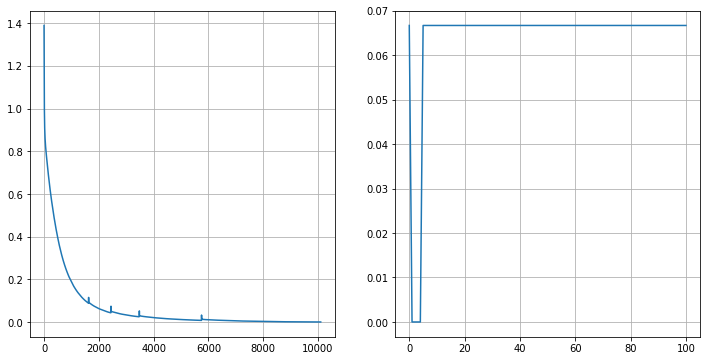

Loss 0.00063
Val Error Rate: 0.06667


In [0]:
bs = 128  # QHAdam のパラメタは変えずに batch size だけ勝手に変えた
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=bs, 
                                     shuffle=True, epochs=10000):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            data.X_valid, data.y_valid, device=device, batch_size=bs)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

In [0]:
trainer.load_checkpoint(tag='best')
error_rate = trainer.evaluate_classification_error(data.X_test, data.y_test, device=device, batch_size=1024)
print('Best step: ', trainer.step)
print("Test Error rate: %0.5f" % (error_rate))
trainer.load_checkpoint()

Loaded logs/year_node_shallow_2020.04.30_11:14/checkpoint_best.pth
Best step:  200
Test Error rate: 0.06667
Loaded logs/year_node_shallow_2020.04.30_11:14/checkpoint_temp_10100.pth


Trainer(
  (model): Sequential(
    (0): DenseBlock(
      (0): ODST(in_features=4, num_trees=1024, depth=6, tree_dim=4, flatten_output=True)
      (1): ODST(in_features=4100, num_trees=1024, depth=6, tree_dim=4, flatten_output=True)
    )
    (1): Lambda()
  )
)

In [0]:
trainer.model(torch.Tensor(data.X_test).to("cuda"))  # class 数 + 1 出力されている

tensor([[-4.3362,  6.2049, -3.0619, -4.7145],
        [-4.5478, -1.1261,  4.5994, -4.6821],
        [-4.2089,  6.2117, -3.4270, -4.6649],
        [-4.4605, -3.8349,  6.4631, -4.5350],
        [ 5.9863, -4.3554, -4.6127, -4.6500],
        [-4.4676, -3.6308,  6.3579, -4.5531],
        [-4.4918, -3.7272,  6.3886, -4.5769],
        [-4.4758, -3.9079,  6.4684, -4.5530],
        [-4.4849, -2.9596,  5.9197, -4.6004],
        [-4.3534, -3.6422,  6.2689, -4.4229],
        [ 6.0878, -4.4479, -4.6719, -4.7246],
        [-4.2174,  6.2042, -3.4125, -4.6578],
        [ 5.9647, -4.3422, -4.5947, -4.6304],
        [ 5.9992, -4.3666, -4.6233, -4.6612],
        [-4.5127, -2.5137,  5.7806, -4.6049]], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [0]:
data.y_test

array([1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2])